In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [257]:
file_path = "C:\\Users\\samoliver.areh\\Downloads\\Forex (Hypothesis).xlsx"
usdsgd = pd.read_excel(file_path)
print(usdsgd)

     Average Type        Date  Range From   Range To  Currency From   \
0           Hourly 2023-10-02            0          0            USD   
1           Hourly 2023-10-02            1          1            USD   
2           Hourly 2023-10-02            2          2            USD   
3           Hourly 2023-10-02            3          3            USD   
4           Hourly 2023-10-02            4          4            USD   
...            ...        ...          ...        ...            ...   
1548        Hourly 2023-12-29           19         19            USD   
1549        Hourly 2023-12-29           20         20            USD   
1550        Hourly 2023-12-29           21         21            USD   
1551        Hourly 2023-12-29           22         22            USD   
1552        Hourly 2023-12-29           23         23            USD   

     Currency To  Ask Price  Bid Price  Mid Price  Ask Change  Bid Change  \
0            SGD     1.3657     1.3652    1.36545    0.000

In [258]:
data = usdsgd.filter(['Bid Change'])
data = data.dropna()
data.head

<bound method NDFrame.head of       Bid Change
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
...          ...
1548   -0.045458
1549   -0.083409
1550    0.121175
1551    0.037853
1552   -0.113688

[1553 rows x 1 columns]>

In [259]:
import math

dataset = data.values
training_data_len = math.ceil(len(data)*0.8)
training_data_len

1243

In [260]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.65790372],
       [0.65790372],
       [0.65790372],
       ...,
       [0.78144462],
       [0.69649564],
       [0.54199635]])

In [261]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 10:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape     


[array([0.65790372, 0.65790372, 0.65790372, 0.65790372, 0.65790372,
       0.68776668, 0.53831179, 0.85187089, 0.66536345, 0.70264246])]
[0.6877208263921019]



(1233, 10, 1)

In [262]:
model = Sequential()
model.add(LSTM(10, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(5, return_sequences = False))
model.add(Dense(3))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

C:\Users\samoliver.areh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1233/1233 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0191


In [263]:
pred = model.predict(x_train)
pred =scaler.inverse_transform(pred)
pred = pd.DataFrame(pred)
y_true = data[:training_data_len]
error = y_true['Bid Change'] - pred[0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


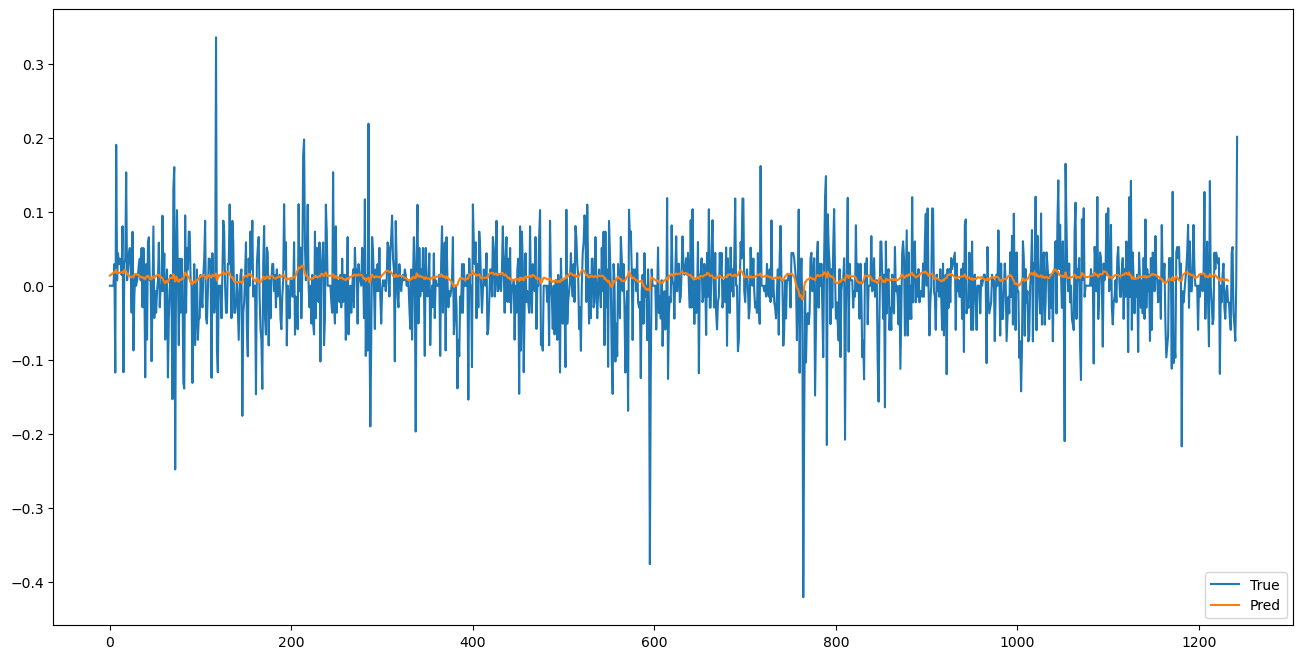

In [264]:
plt.figure(figsize=(16,8))
plt.plot(y_true['Bid Change'])
plt.plot(pred[0])
plt.legend(['True', 'Pred'], loc = 'lower right')

In [265]:
res = error.dropna()

In [266]:
mae = np.mean(abs(res))
rmse = np.sqrt(np.mean(np.square(res)))

print(rmse)
print(mae)

0.05868239877601779
0.04202662299612548


In [267]:
test_data = scaled_data[training_data_len - 10: , :]
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [268]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\samoliver.areh\AppData\Local\Temp\ipykernel_24256\3277763010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


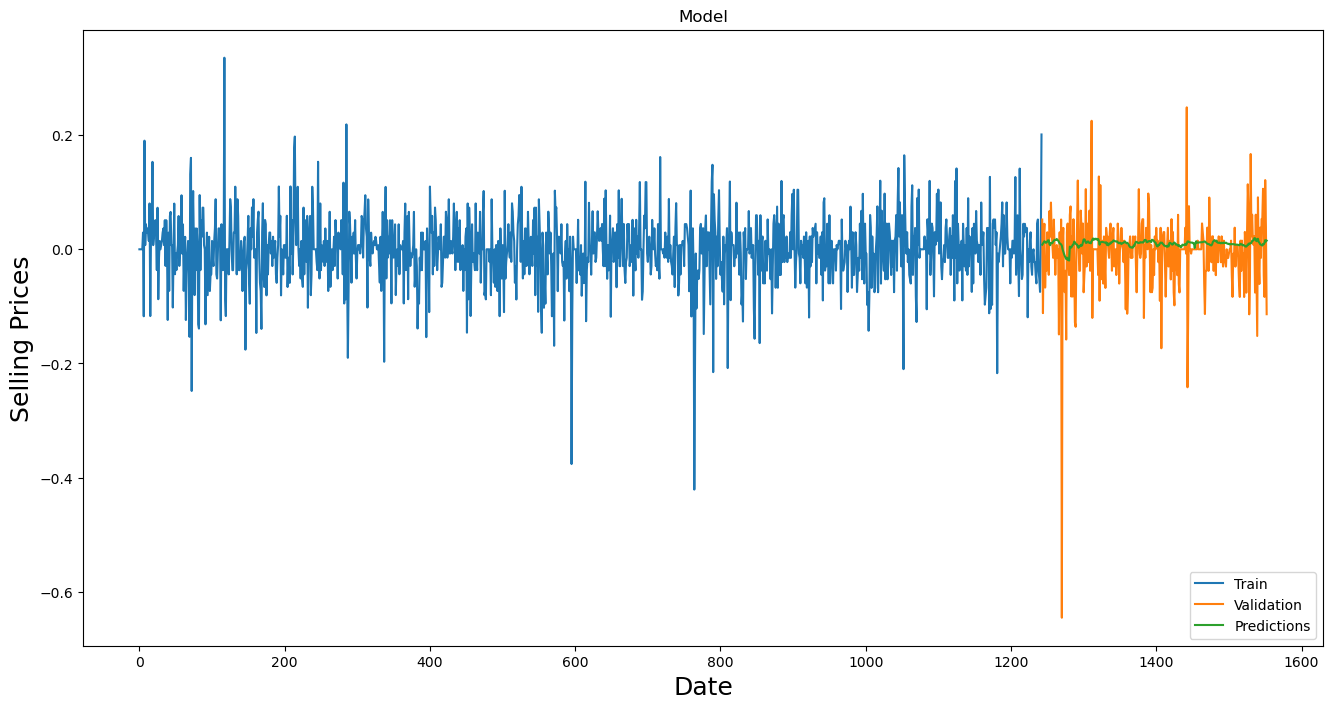

In [269]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel("Selling Prices", fontsize = 18)
plt.plot(train['Bid Change'])
plt.plot(valid[['Bid Change', 'Predictions']])
plt.legend(['Train', "Validation", 'Predictions'], loc = 'lower right')
plt.show()